In [1]:
using Pkg
using Revise
Pkg.activate("./scripts/julia_modules/JuliaClusterAndTreeTools")
using JuliaClusterAndTreeTools
using Statistics
using Pkg
using RCall
using DataFrames
using StatsBase
using CSV
R"""
library(ggplot2)
library(fitdistrplus)
library(patchwork)
library(fitdistrplus)
library(data.table)

"""



  Activating project at `./scripts/julia_modules/JuliaClusterAndTreeTools`
┌ Warning: RCall.jl: Loading required package: MASS
│ Loading required package: survival
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘patchwork’
│ 
│ The following object is masked from ‘package:MASS’:
│ 
│     area
│ 
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


RObject{StrSxp}
 [1] "data.table"   "patchwork"    "fitdistrplus" "survival"     "MASS"        
 [6] "ggplot2"      "stats"        "graphics"     "grDevices"    "utils"       
[11] "datasets"     "methods"      "base"        


In [2]:
in_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz"
rows_after_filter = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_rows.txt"
columns_after_filter = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_kept_columns.txt"

keepPositionsFraction = 0.8
topNhaving_sequences_to_remove = 10
reference_seq_id = "England/ALDP-3C3EB7C/2022"
country = "England"

"England"

In [ ]:
aln = JuliaClusterAndTreeTools.Alignment(in_file_name)
#aln = JuliaClusterAndTreeTools.Alignment("/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade.fasta.gz")
print("Alignment parsed")
initial_length = size(aln.M)[2]
reference_seq = collect(join(aln.M[aln.name_sequence_map[reference_seq_id],:]))
print("Initial length and reference sequence saved")

Reading aligment audines11/rez/lineages/B.1.1.7/alignment_nextclade.fasta.gz



In [5]:
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
print("Initial statistics on gaps and N done")

Doing transposition...
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...
Initial statistics on gaps and N done

Initial distribution of gaps across the alignment


┌ Warning: RCall.jl: Warning: Removed 310 rows containing missing values (`geom_point()`).
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


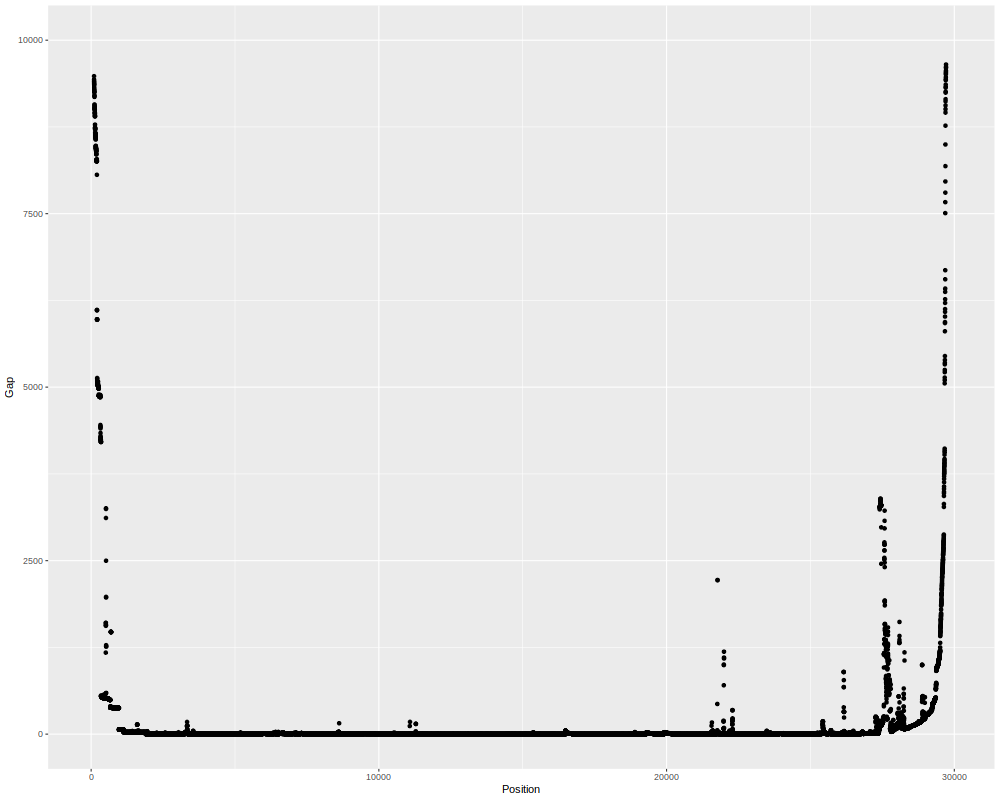

RObject{VecSxp}


In [11]:
@rput dc

println("Initial distribution of gaps across the alignment")
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc) + geom_point(aes(x=Position,y=Gap)) + ylim(0,10000)
p
"""

76.0

In [19]:
blacklist_positions = Array{Int64,1}()
# array to keep column indices to be discarded

Int64[]

In [22]:
# remove tails down to first 5 percentile
Glim = percentile(dc.N,5)
starti = undef
endi = undef
lenAln = size(dc)[1]
for i in  2:lenAln
    if dc.Gap[i] <= Glim && dc.Gap[i-1] <= Glim
        starti = i
        break
    else
        push!(blacklist_positions,i)
    end
end

for i in  1:lenAln-1
    ie = lenAln-i+1
    if dc.Gap[ie] <= Glim  && dc.Gap[ie+1] <= Glim
        endi = ie
        break
    else
        push!(blacklist_positions,ie)
    end
end
println("Non gapped alignment starts at this position: ",starti)
println("Gaps terminate alignment at this position",endi)
#JuliaClusterAndTreeTools.sub_alignment!(aln,starti:endi)

Non gapped alignment starts at this position: 967
Gaps terminate alignment at this position28301


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


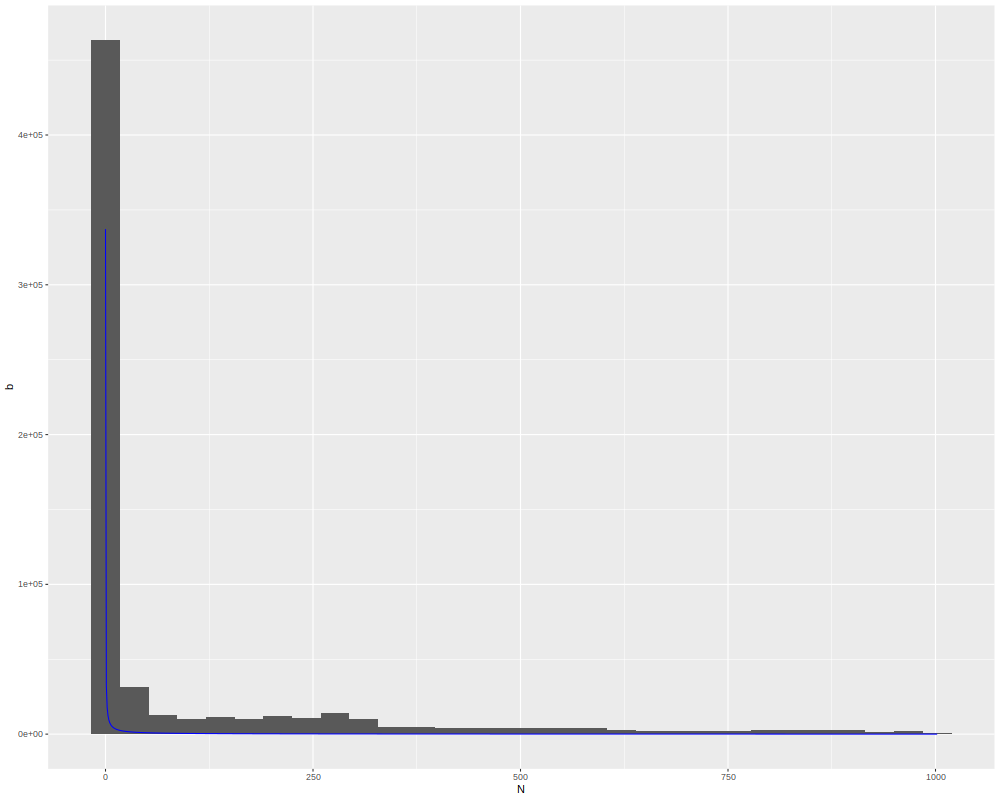

RObject{VecSxp}


In [23]:
@rput dr
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
fit <- fitdist(dr$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=dr) + geom_histogram(aes(x=N))
xvals <- dr$N
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(dr)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue")
p
"""
# library(fitdistrplus)
# fit <- fitdist(dc$N, "nbinom")
# mu = as.double(fit$estimate["mu"][[1]])
# size = as.double(fit$estimate["size"][[1]])
# fitD <- dnbinom(0:60, size=size, mu=mu)

In [24]:
maxNlimit = percentile(dr.N,100-topNhaving_sequences_to_remove)
println("Sequences having N more than ",maxNlimit, " will be removed")
keep_ids = dr.ID[dr.N .< maxNlimit]
sub_alignment!(aln,keep_ids)
println("Alignment size after removal of top most N having sequences")
println(size(aln.M))
#println(maximum(dr.N))

Sequences having N more than 119.0 will be removed
Alignment size after removal of top most N having sequences
(517514, 29903)


In [25]:
println("Recalculatig data on N and Gaps per sequence - rowwise ")
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
print("")

Recalculatig data on N and Gaps per sequence - rowwise 
Doing transposition...
Done. Converting to a data frame...


replot dta on N rowwise


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


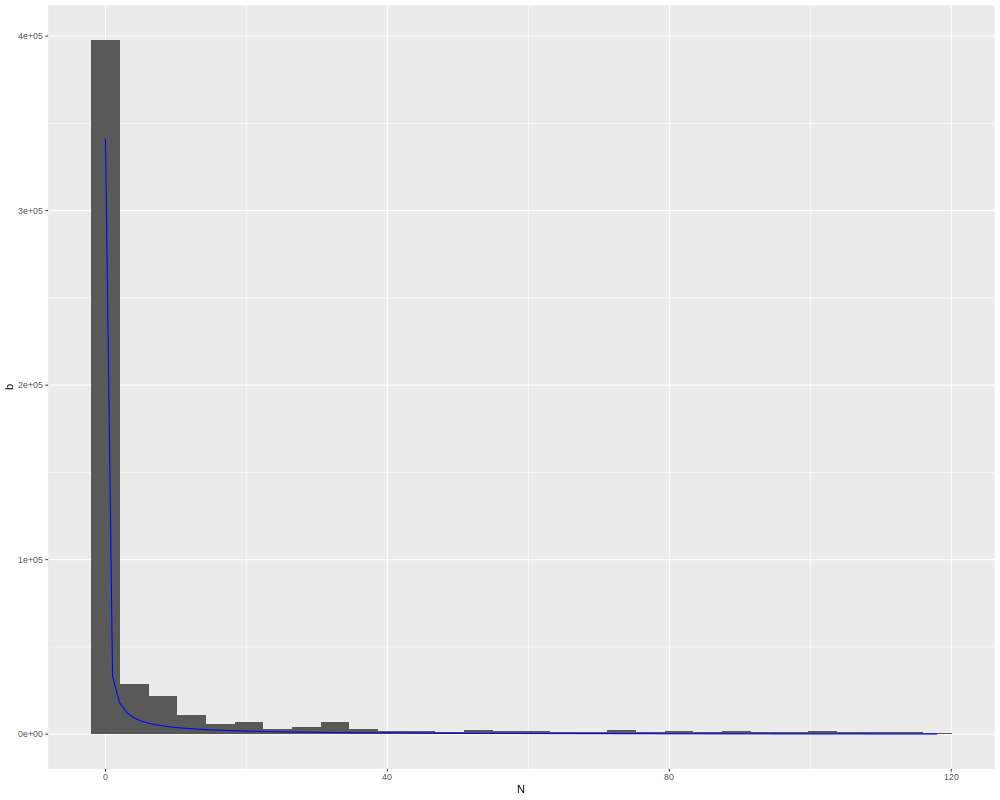

RObject{VecSxp}


In [26]:
println("replot data on N rowwise")
@rput dr
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
fit <- fitdist(dr$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=dr) + geom_histogram(aes(x=N))
xvals <- dr$N
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(dr)
df = data.table(a=xvals,b=fitD)
p <- p + geom_line(data = df, aes(a,b),color="blue")
p
"""

In [27]:
println("Recalculating statistics on N columnwise")
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
print("")

Recalculating statistics on N columnwise
Doing transposition...
Done. Converting to a data frame...
Done


In [28]:
# get a subset of columns without terminal gaps
dc_woterminalgaps = filter(:Position => !in(blacklist_positions), dc)
print("")

Distribution of N across columns after removal of terminal gappy regions


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


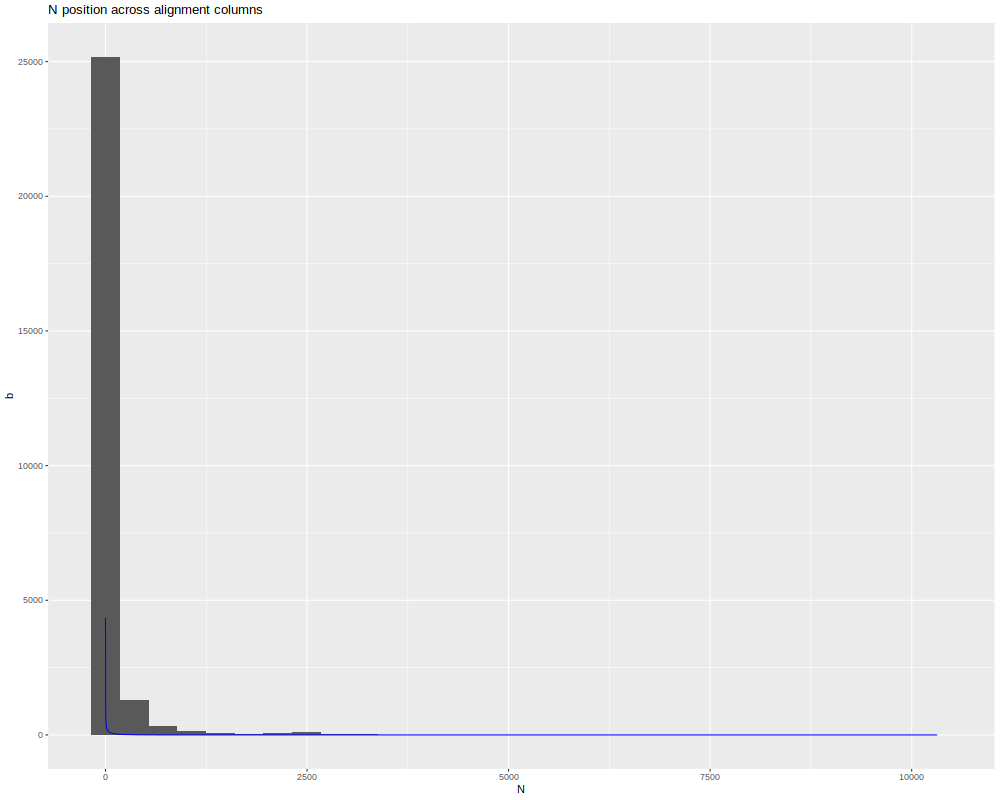

RObject{VecSxp}


In [29]:
println("Distribution of N across columns after removal of terminal gappy regions")
@rput dc_woterminalgaps
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
df <- dc_woterminalgaps
fit <- fitdist(df$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
df = data.table(a=xvals,b=fitD)
p_dc_woterminalgaps <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
p_dc_woterminalgaps
"""

In [30]:
#get the limit of n to remove
@rput keepPositionsFraction dc
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))

R"""
fit <- fitdist(dc_woterminalgaps$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
maxNlimit = qnbinom(keepPositionsFraction, mu = mu, size = size)
"""
@rget maxNlimit
println("Keeping ",keepPositionsFraction," fraction of sequences we allow maximum number of Ns per sequence   ",maxNlimit)

Keeping 0.8 fraction of sequences we allow maximum number of Ns per sequence   131.0


Distributin of N across sequence

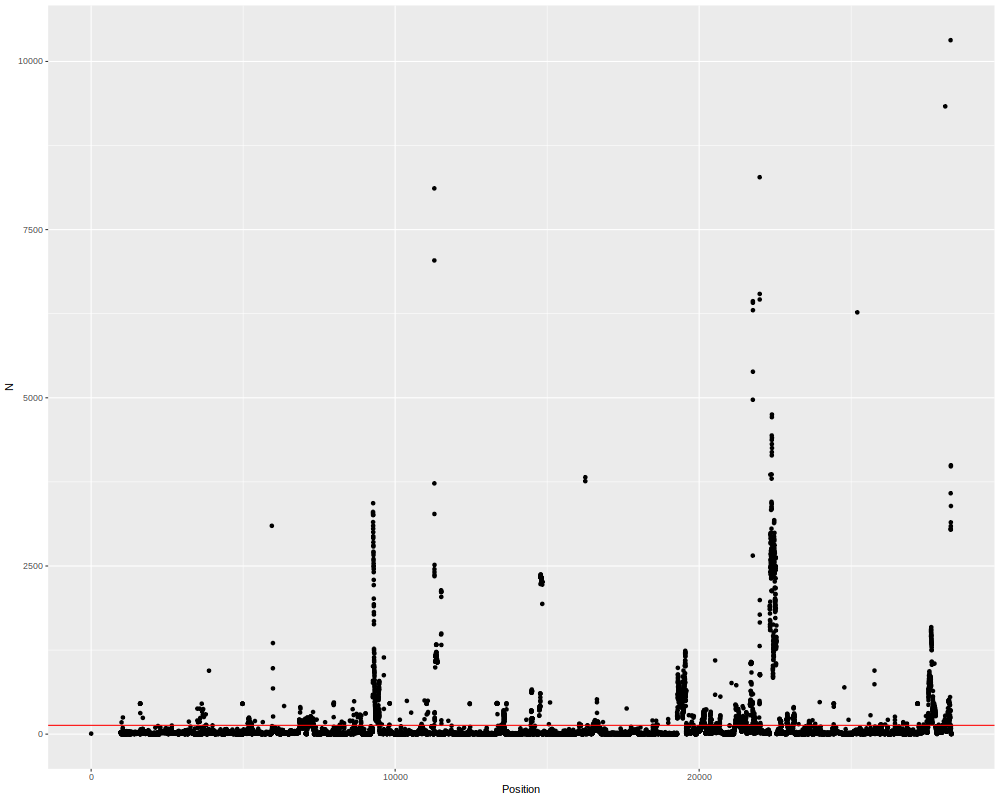

RObject{VecSxp}


In [31]:
print("Distributin of N across sequence")
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
pnas <- ggplot(data=dc_woterminalgaps) + geom_point(aes(x=Position,y=N)) + geom_hline(yintercept=maxNlimit,color="red")
pnas
"""

In [32]:
#print filter put columns based on the N threathhold
dc_woterminalgaps_woN = filter(:N => <=(maxNlimit) ,dc_woterminalgaps) # 
sub_alignment_columnwise!(aln,dc_woterminalgaps_woN.Position)
println("Size of the trimmed alignment aqfter removing terminal gappy columns and columns with more than $maxNlimit Ns ")
println(size(aln.M))
#sub_alignment!(aln,dc_woterminalgaps_woN.Position)

Size of the trimmed alignment aqfter removing terminal gappy columns and columns with more than 131.0 Ns 
(517514, 24487)


In [33]:
println("writing down the kept columns to $columns_after_filter")
CSV.write(columns_after_filter, dc_woterminalgaps_woN[:,["Position"]],writeheader=false)


writing down the kept columns to audines11/rez/lineages/B.1.1.7/alignment_nextclade_filtered_keptcolumns_0.8_20.txt


"audines11/rez/lineages/B.1.1.7/alignment_nextclade_filtered_keptcolumns_0.8_20.txt"

In [34]:
print("Test sequence with removed high N content columns")
dc2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
@rput dc2 dr2
print("")

Doing transposition...oved high N content columnsCounted 1000 columns
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...


┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


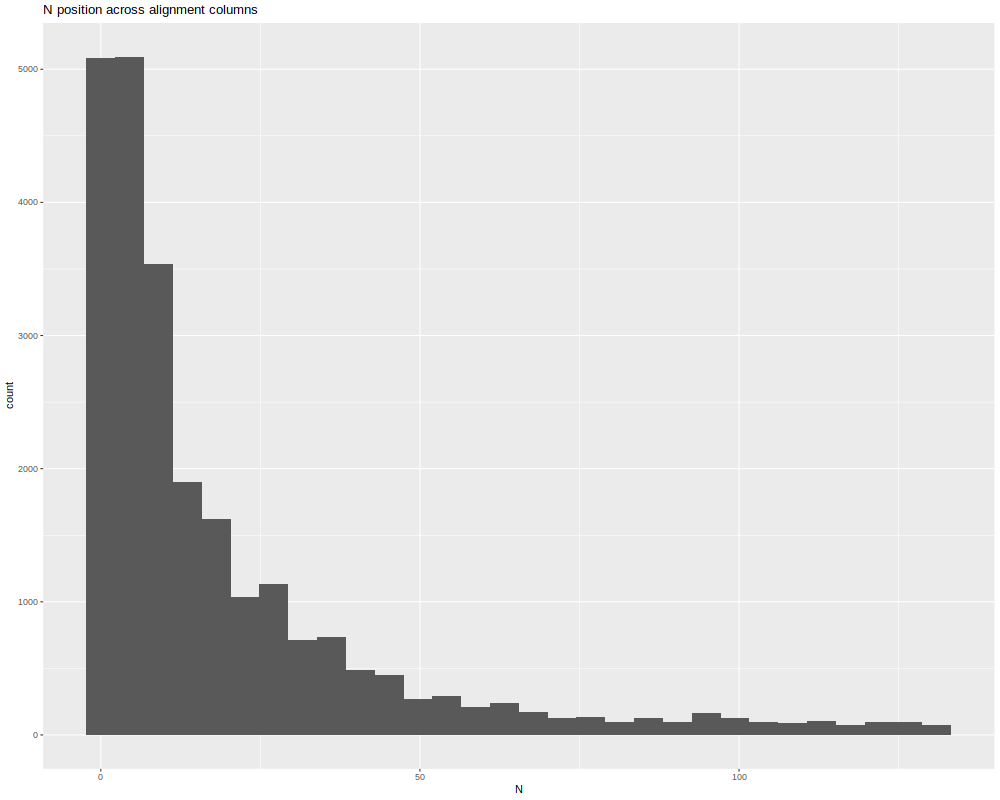

RObject{VecSxp}


In [35]:
R"""
df <- dc2
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
p <- ggplot(data=df) + geom_histogram(aes(x=N))
p <- p + ggtitle("N position across alignment columns")
p
"""
# xvals <- seq(0,max(df$N),2)
# fitD <- dnbinom(xvals, size=size, mu=mu)*nrow(df)
# df = data.table(a=xvals,b=fitD)
# p <- p + geom_line(data = df, aes(a,b),color="blue") + ggtitle("N position across alignment columns")
# p
# """

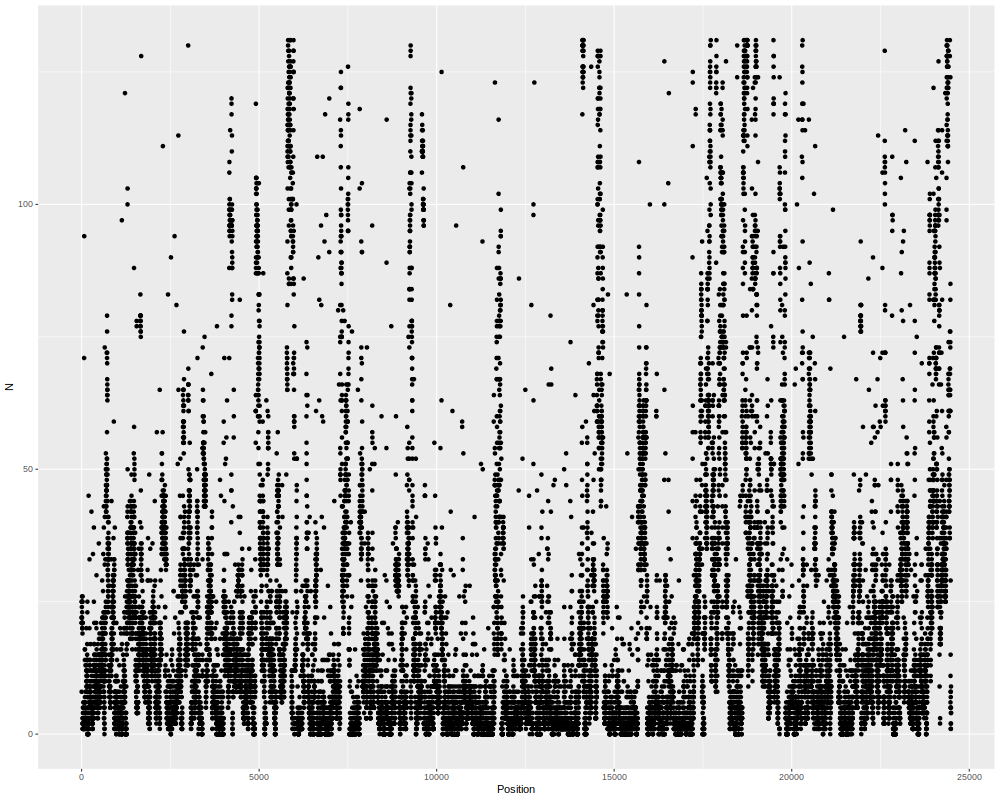

RObject{VecSxp}


In [36]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc2) + geom_point(aes(x=Position,y=N))
p
"""

┌ Warning: RCall.jl: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


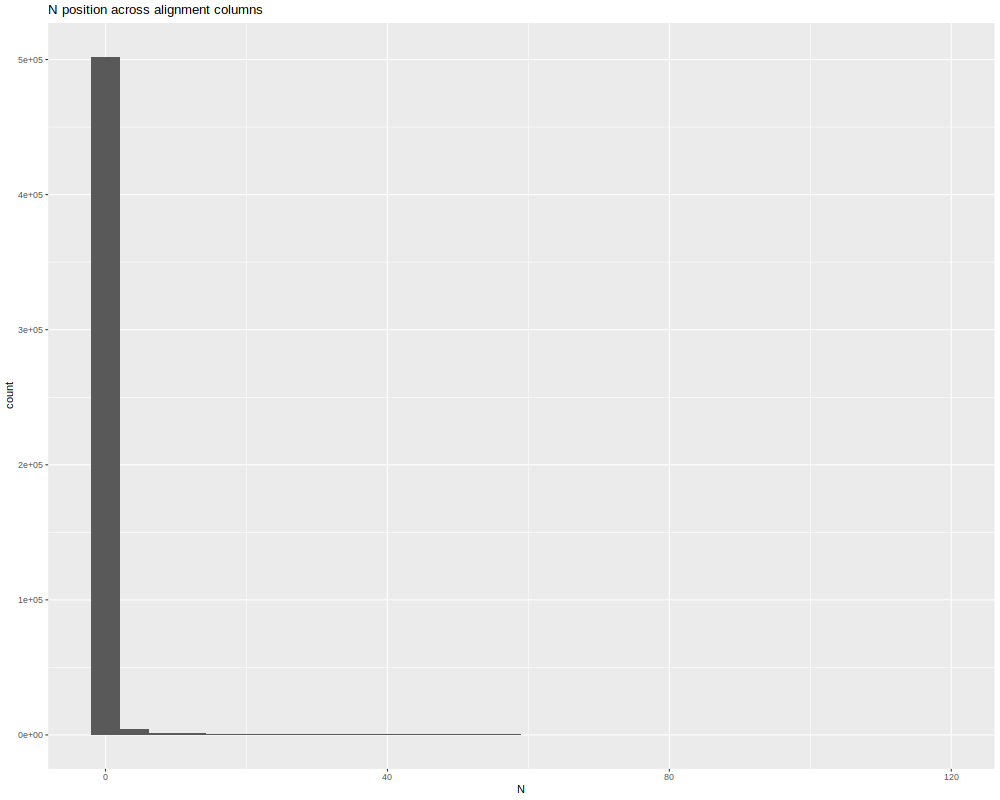

RObject{VecSxp}


In [37]:
R"""
df <- dr2
p <- ggplot(data=df) + geom_histogram(aes(x=N))
xvals <- seq(0,max(df$N),2)
p <- p + ggtitle("N position across alignment columns")
p
"""

┌ Warning: RCall.jl: Warning: The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
│ ℹ Please use `after_stat(count)` instead.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


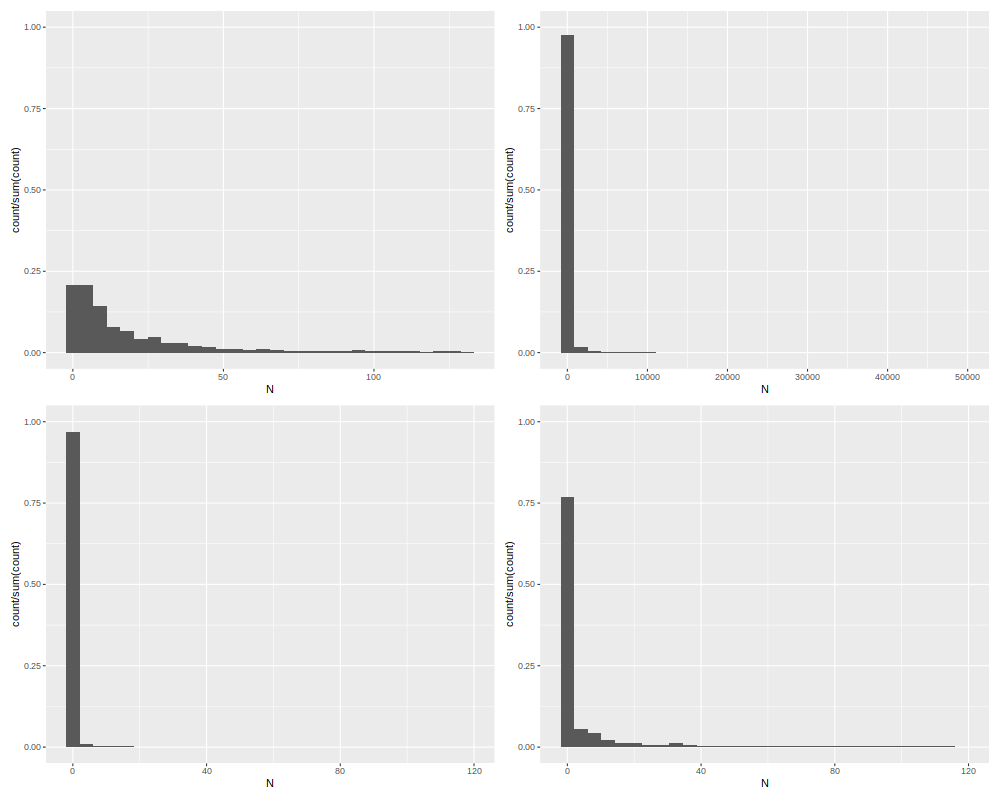

RObject{VecSxp}


In [38]:
@rput dc dc2 dr dr2
R"""
pini<-ggplot(dc, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
p<-ggplot(dc2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

pinir<-ggplot(dr, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
pr<-ggplot(dr2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

(p|pini)/(pr|pinir)
"""

In [39]:
dr2_N0 = filter(row -> row.N ==0, dr2)
print("Kept ",round(size(dr2_N0)[1]/size(dr2)[1],digits=2)," ",size(dr2_N0)[1])
sub_alignment!(aln, dr2_N0.ID)
println(size(aln.M))
CSV.write(rows_after_filter, dr2_N0[:,["ID"]],writeheader=false)

Kept 0.91 471766